## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


# 1. Business Understanding

Microsoft has decided to directly enter the entertainment industry, specifically, by creating a new movie studio. However, the new Head of the Movie Studio does not have significant experience in this space, and needs our help in understanding what types of films are doing the best at the box office. After requesting additional detail from the new Head, she is really interested in the following:

    - What genres of movies are the most profitable at the box office (i.e. released in theatres)?
    - Do ratings of movies have any type of correlation with how well they do in theatres?
    - What timeline for release should Microsoft aim for?

While answering these key questions and summarizing key findings, Microsoft's Head of Movie Studio is looking for three concrete recommendations or actionable insights that can guide her in deciding what type of movie(s) to create.

Our data understanding, exploration, and analysis are detailed in the sections below, resulting in simple yet powerful vizualizations that support our final recommendations.

# 2. Data Understanding

This section contains our detailed procedures and observations as it pertains to understanding the data that is available for responding to this request from the Head of Microsoft's new Movie Studio. The data sources we will be  understanding include:
    * [Box Office Mojo](https://www.boxofficemojo.com/)
    * [IMDB](https://www.imdb.com/)
    * [Rotten Tomatoes](https://www.rottentomatoes.com/)
    * [TheMovieDB](https://www.themoviedb.org/)
    * [The Numbers](https://www.the-numbers.com/)
    
Although using API and webscraping is always an option, based on the deadline and based on the results of our data understanding procedures, we felt we had the necessary data and information to move forward with our analysis.

Some examples of data understanding procedures that will be discussed below include:
    - Using methods to understand the makeup of each data source
    - Review a sample of specific records within each data file
    - Identifying the data types within each data file and assessing whether they will need to be modified
    - Identifying any unique and/or foreign keys and IDs within the available data sources
    - Determining whether we will need to use webscraping or APIs to extract other relevant data from publically available sources
    - Comparing summary metrics between data sources that may have overlapping information (e.g. release date, sales, etc.) 

The first step to begin the data understanding and exploration process is to import the libraries that we will need to use. Based on our preliminary understanding of the data sources, we import the following:
   - SQLite3
   - Panda
   - Numpy
   - Matplotlib
   - Seaborn

In [1]:
# Your code here - remember to use markdown cells for comments as well!
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

We attempted to API some additional data from TMDB but were unable to troubleshoot.

In [2]:
# Testing to see if we can bring and API in to supplement our data
import requests
import json
url = 'https://api.themoviedb.org/3/movie/{movie_id}?api_key=<<503f12af247746f5fc6113f4fed1f3a3>>&language=en-US'
TMDB = requests.get(url)

In [3]:
type(TMDB)

requests.models.Response

In [4]:
# Attemp to access an API
TMDB.status_code

401

In [5]:
TMDB_data = TMDB.json()

Next, we unzip the zipfile (im.db.zip) so that we can read in the contents using SQLite3.

In [6]:
#Unzipping the IMDB SQL data
from zipfile import ZipFile

# specifying the zip file name
file_name = "./zippedData/im.db.zip"

# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:

    zip.printdir()   # printing all the contents of the zip file
    print('Extracting all the files now...')
    
    zip.extractall() # extracting all the files
    print('Done!')

File Name                                             Modified             Size
im.db                                          2021-12-20 16:31:38    169443328
Extracting all the files now...
Done!


In [7]:
#Establish the SQL connection, establish the cursor and execute the SQL query
conn = sqlite3.connect('im.db')
cur = conn.cursor()
cur.execute("""SELECT name FROM sqlite_master WHERE type = 'table';""")

# Fetch the result and store it in table_names. View the table_name to confirm that all tables were retrieved.
table_names = cur.fetchall()
table_names

[('movie_basics',),
 ('directors',),
 ('known_for',),
 ('movie_akas',),
 ('movie_ratings',),
 ('persons',),
 ('principals',),
 ('writers',)]

We can see that the tables are located within table_names.


We then open and read the CSV and TSV files into a separate dataframe for each source data. For the Rotten Tomatoes Reviews dataframe, we had to include a "tab" separator and change the encoding to 'windows-1252'.

In [8]:
# Opening and reading all five csv and tsv data into a respective dataframe
TN_DF = pd.read_csv("./zippedData/tn.movie_budgets.csv.gz")
ROT_TOM_INFO_DF = pd.read_csv("./zippedData/rt.movie_info.tsv.gz", sep="\t")
ROT_TOM_REV_DF = pd.read_csv("./zippedData/rt.reviews.tsv.gz", sep="\t", encoding='windows-1252')
TMDB_DF = pd.read_csv("./zippedData/tmdb.movies.csv.gz")
BOM_DF = pd.read_csv("./zippedData/bom.movie_gross.csv.gz")



Now that all the source data files have been read into each respective dataframe, we use methods including but not limited to .info(), .head(), and .describe(), and .shape to understand the makeup of each dataframe. 

In [9]:
TN_DF.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"


In [10]:
TN_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [11]:
TN_DF.describe(include = 'all')

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
count,5782.000000,5782,5782,5782,5782,5782
unique,NaN,2418,5698,509,5164,5356
top,NaN,"Dec 31, 2014",Halloween,"$20,000,000",$0,$0
freq,NaN,24,3,231,548,367
mean,50.372363,NaN,NaN,NaN,NaN,NaN
std,28.821076,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN
25%,25.000000,NaN,NaN,NaN,NaN,NaN
50%,50.000000,NaN,NaN,NaN,NaN,NaN
75%,75.000000,NaN,NaN,NaN,NaN,NaN


TN_DF Observations - We can see that The Numbers data has some pertinent financial information, including the budget, domestic gross sales, worldwide sales, and release date. There are also 5,782 records in the dataframe and 5 of the 6 series have a data type of object (string). These will need to be converted to float or possibly integers.

In [12]:
ROT_TOM_INFO_DF.head(5)

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


In [13]:
ROT_TOM_INFO_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


In [14]:
ROT_TOM_INFO_DF.describe(include = 'all')

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
count,1560.000000,1498,1557,1552,1361,1111,1201,1201,340,340,1530,494
unique,NaN,1497,6,299,1125,1069,1025,717,1,336,142,200
top,NaN,A group of air crash survivors are stranded in...,R,Drama,Steven Spielberg,Woody Allen,"Jan 1, 1987","Jun 1, 2004",$,"200,000",90 minutes,Universal Pictures
freq,NaN,2,521,151,10,4,8,11,340,2,72,35
mean,1007.303846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,579.164527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,504.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1007.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,1503.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


ROT_TOM_INFO_DF Observations - We can see that the dataframe does not have a movie name, just an ID. Also, the data frame contains 1,560 records, but many of the series' have null values that will need to be cleaned if we choose to select this dataframe.

Although there is some interesting information not included in TN_DF, such as genre, director, writor, and dvd_date, we don't believe this information to be as relevant for our analysis due to other considerations. For examples, although directors and writers are important, Microsoft may not be able to get the desired directors and writers, as its the company 1st movies. The top directors are typically booked out well in advance. The genre field seems to combine multiple genres using 'and'. Hopefully, other dataframes have a more usable genre column.

Lastly, the currency and box office columns have only 340 non-null entries. Therefore, there isn't enough data here to really be able to use these metrics.

In [15]:
ROT_TOM_REV_DF.head()

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


In [16]:
ROT_TOM_REV_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   review      48869 non-null  object
 2   rating      40915 non-null  object
 3   fresh       54432 non-null  object
 4   critic      51710 non-null  object
 5   top_critic  54432 non-null  int64 
 6   publisher   54123 non-null  object
 7   date        54432 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB


ROT_TOM_REV_DF Observations - Again, no movie titles in this dataframe. Although you don't necessarily need movie titles, it does add a sense of credibility and comfort with the data. The other remaining reviewer fields do not seem relevant to our analysis and stated business purpose.

Here, we are going to analyze and understand the IMDB data tables that were extracted using SQL queries. First we need to read certain SQL tables into a respective Dataframe. Below, we fetch the data from the movie_ratings and movie_basics tables into respective dataframes and then similar to procedures above, understand the structure and makeup of each dataframe.

In [17]:
#read the SQL table movie_ratings into a dataframe using the SELECT * query
IMDB_ratings = pd.DataFrame(
    data=cur.execute("""SELECT * FROM movie_ratings;""").fetchall(),
    columns=[x[0] for x in cur.description]
)
IMDB_ratings.shape

(73856, 3)

In [18]:
#read the SQL table movie_basics into a dataframe using the SELECT * query
IMDB = pd.DataFrame(
    data=cur.execute("""SELECT * FROM movie_basics;""").fetchall(),
    columns=[x[0] for x in cur.description]
)

In [19]:
IMDB.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [20]:
IMDB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [21]:
IMDB.describe(include = 'all')

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
count,146144,146144,146123,146144.000000,114405.000000,140736
unique,146144,136071,137773,NaN,NaN,1085
top,tt7668406,Home,Broken,NaN,NaN,Documentary
freq,1,24,19,NaN,NaN,32185
mean,NaN,NaN,NaN,2014.621798,86.187247,NaN
std,NaN,NaN,NaN,2.733583,166.360590,NaN
min,NaN,NaN,NaN,2010.000000,1.000000,NaN
25%,NaN,NaN,NaN,2012.000000,70.000000,NaN
50%,NaN,NaN,NaN,2015.000000,87.000000,NaN
75%,NaN,NaN,NaN,2017.000000,99.000000,NaN


IMDB (movie basics) Observations - This dataframe has 146,144 records but all of them appear to be for movies after 2010 (minimum start year). It also has the associated genres for each record and very few null values overall. This is a very useful and thorough dataset to consider in our analysis.

In [22]:
IMDB_ratings.head()

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [23]:
IMDB_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


In [24]:
IMDB_ratings.describe(include = 'all')

,movie_id,averagerating,numvotes
count,73856,73856.000000,7.385600e+04
unique,73856,NaN,NaN
top,tt1579252,NaN,NaN
freq,1,NaN,NaN
mean,NaN,6.332729,3.523662e+03
std,NaN,1.474978,3.029402e+04
min,NaN,1.000000,5.000000e+00
25%,NaN,5.500000,1.400000e+01
50%,NaN,6.500000,4.900000e+01
75%,NaN,7.400000,2.820000e+02


IMDB Ratings Observations - This dataframe has 73,856 records, and only has 3 columns. It has a movie id field that we can use for merging with IMDB dataframe above, and has average ratings and number of votes. This dataframe will be useful in our analysis and easier to merge then others with review data. 

### Key Observations from Data Understanding Procedures:
   - We will use the IMDB, IMDB_ratings and the TN_DF dataframe for our analysis
   - We have chosen to not analyze certain categories, like directors, writers, rating (R, PG13), and studio. Although we realize these could be relevant, due to limitations in the data, this being Microsoft's first movie, and the tight deadline, we felt that it would be appropriate to exclude and come back to them if time permits.
   - The data types will need to be changed during the data preparation procedures
   - Certain columns have null or NA values, and these will need to be replaced or removed from the data set
   - IMDB and IMDB_ratings both have a movie_id field that we can join on, but we will need to use the movie title and release year to merge with the TN_DF dataframe

# 3. Data Preparation

In this section of our Notebook, we will begin to prepare and cleanse the selected data files. This includes, but is not limited to:
 - Creating copies of the original dataframes
 - Removing or replacing null values
 - Stripping strings, including leading and trailing spaces
 - Changing data types
 - Adding or removing columns or fields
 - Creating new dataframes, lists, or dictionaries, where needed
 - Merging dataframes
 
We want to make sure the data is in the best possible format, with minimal or no errors/inconsistencies, so that we can focus on data analysis in the next section.

We start with cleaning and prepping the The Numbers dataframe.

In [25]:
#Create a copy and rename it as "clean"
TN_clean = TN_DF.copy()

#Drop the id field as there are lots of duplicates and we don't need it
TN_clean.drop('id', axis=1, inplace=True)

# Strip the $ sign so we can convert to int or float
TN_clean['production_budget'] = TN_clean['production_budget'].map(lambda x: x.strip('$,'))
TN_clean['domestic_gross'] = TN_clean['domestic_gross'].map(lambda x: x.strip('$,'))
TN_clean['worldwide_gross'] = TN_clean['worldwide_gross'].map(lambda x: x.strip('$,'))

# strip the ','
TN_clean = TN_clean.apply(lambda x: x.str.replace(',', ''))

#Change data types to int
TN_clean[['production_budget', 'domestic_gross', 'worldwide_gross']] = TN_clean[['production_budget', 'domestic_gross', 'worldwide_gross']].apply(pd.to_numeric)

#Change release_date to datetime type 
TN_clean['release_date'] = pd.to_datetime(TN_clean['release_date'])


#Add the release_year so we can merge on multiple columns (year and title)
TN_clean['release_year'] = pd.DatetimeIndex(TN_DF['release_date']).year
TN_clean['release_month'] = pd.DatetimeIndex(TN_DF['release_date']).month

#check work
TN_clean.head(2)

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month
0,2009-12-18,Avatar,425000000,760507625,2776345279,2009,12
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011,5


In [26]:
TN_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       5782 non-null   datetime64[ns]
 1   movie              5782 non-null   object        
 2   production_budget  5782 non-null   int64         
 3   domestic_gross     5782 non-null   int64         
 4   worldwide_gross    5782 non-null   int64         
 5   release_year       5782 non-null   int64         
 6   release_month      5782 non-null   int64         
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 316.3+ KB


Next, we add profitability metrics to the TN_clean data set, including: 1) Net Income 2) Net Income Ratio and 3) ROI.

In [27]:
TN_clean['Net Income'] = TN_clean['worldwide_gross'] - TN_clean['production_budget']
TN_clean['Net_Income_Ratio'] = TN_clean['Net Income'] / TN_clean['worldwide_gross']
TN_clean['ROI'] = TN_clean['Net Income'] / TN_clean['production_budget']

In [28]:
TN_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       5782 non-null   datetime64[ns]
 1   movie              5782 non-null   object        
 2   production_budget  5782 non-null   int64         
 3   domestic_gross     5782 non-null   int64         
 4   worldwide_gross    5782 non-null   int64         
 5   release_year       5782 non-null   int64         
 6   release_month      5782 non-null   int64         
 7   Net Income         5782 non-null   int64         
 8   Net_Income_Ratio   5782 non-null   float64       
 9   ROI                5782 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(6), object(1)
memory usage: 451.8+ KB


We are first creating a copy of the IMDB dataframe and then cleansing it to remove "N/A" or "Null" values from the "genres" and "original_title" field. 
We do not remove N/A values for runtime minutes, as this is a significant number of movies and runtime is not a major consideration in our analysis.

We then sort all movies by "runtime_minutes" (highest to lowest) and remove duplicates where the movie name and year were the same (i.e. multiple entries in IMDB).

In [29]:
IMDB.isna().sum()

movie_id               0
primary_title          0
original_title        21
start_year             0
runtime_minutes    31739
genres              5408
dtype: int64

In [30]:
IMDB_clean2 = IMDB.copy()
IMDB_clean2 = IMDB_clean2.dropna(subset = ['genres'])
IMDB_clean2 = IMDB_clean2.dropna(subset = ['original_title'])
IMDB_clean2 = IMDB_clean2.sort_values(by='runtime_minutes', ascending = False)
IMDB_clean2.isna().sum()

movie_id               0
primary_title          0
original_title         0
start_year             0
runtime_minutes    28502
genres                 0
dtype: int64

In [31]:
#drop duplicate records based on the title and start year
IMDB_clean2 = IMDB_clean2.drop_duplicates(subset = ['original_title','start_year'], keep = 'first')
IMDB_clean2

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
132389,tt8273150,Logistics,Logistics,2012,51420.0,Documentary
44840,tt2659636,Modern Times Forever,Modern Times Forever,2011,14400.0,Documentary
123467,tt7492094,Nari,Nari,2017,6017.0,Documentary
87264,tt5068890,Hunger!,Hunger!,2015,6000.0,"Documentary,Drama"
88717,tt5136218,London EC1,London EC1,2015,5460.0,"Comedy,Drama,Mystery"
...,...,...,...,...,...,...
146131,tt9915790,Bobbyr Bondhura,Bobbyr Bondhura,2019,NaN,Family
146138,tt9916428,The Secret of China,The Secret of China,2019,NaN,"Adventure,History,War"
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy


We are now merging the IMDB Clean2 and IMDB Ratings using the movie ID field. Then we will merge that dataframe with the TN_clean file on two conditions - movie name and start year. In order to apply and merge on the start year condition, we will first need to create a column "release year" within the TN_clean dataframe.

We perform a "left" merge, as we don't want to lose any movies for which ratings were not available. They are still useful for our analysis of genres and release month.

In [32]:
IMDB_Merged = pd.merge(IMDB_clean2,IMDB_ratings,on='movie_id', how = 'left')
IMDB_Merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139302 entries, 0 to 139301
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         139302 non-null  object 
 1   primary_title    139302 non-null  object 
 2   original_title   139302 non-null  object 
 3   start_year       139302 non-null  int64  
 4   runtime_minutes  111276 non-null  float64
 5   genres           139302 non-null  object 
 6   averagerating    72494 non-null   float64
 7   numvotes         72494 non-null   float64
dtypes: float64(3), int64(1), object(4)
memory usage: 9.6+ MB


Finally, we merge the combined IMDB dataframe with TN_clean dataframe. We perform an "inner" merge, as our analysis requires financial metrics. If we don't have it for a given movie, then we don't need it in our dataframe.

In [33]:
Movies_DF = pd.merge(TN_clean, IMDB_Merged, left_on = ["movie","release_year"], right_on = ["original_title","start_year"], how = "inner")
Movies_DF.sort_values(by='Net Income', ascending= False)

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month,Net Income,Net_Income_Ratio,ROI,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
3,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200,2018,4,1748134200,0.853525,5.827114,tt4154756,Avengers: Infinity War,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,670926.0
23,2015-06-12,Jurassic World,215000000,652270625,1648854864,2015,6,1433854864,0.869606,6.669092,tt0369610,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",7.0,539338.0
18,2012-05-04,The Avengers,225000000,623279547,1517935897,2012,5,1292935897,0.851772,5.746382,tt0848228,The Avengers,The Avengers,2012,143.0,"Action,Adventure,Sci-Fi",8.1,1183655.0
27,2018-02-16,Black Panther,200000000,700059566,1348258224,2018,2,1148258224,0.851660,5.741291,tt1825683,Black Panther,Black Panther,2018,134.0,"Action,Adventure,Sci-Fi",7.3,516148.0
72,2018-06-22,Jurassic World: Fallen Kingdom,170000000,417719760,1305772799,2018,6,1135772799,0.869809,6.681016,tt4881806,Jurassic World: Fallen Kingdom,Jurassic World: Fallen Kingdom,2018,128.0,"Action,Adventure,Sci-Fi",6.2,219125.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,2020-02-21,Call of the Wild,82000000,0,0,2020,2,-82000000,-inf,-1.000000,tt7504726,Call of the Wild,Call of the Wild,2020,NaN,"Adventure,Animation,Family",NaN,NaN
241,2017-12-13,Bright,90000000,0,0,2017,12,-90000000,-inf,-1.000000,tt5519340,Bright,Bright,2017,117.0,"Action,Crime,Fantasy",6.4,147834.0
190,2019-06-14,Men in Black: International,110000000,3100000,3100000,2019,6,-106900000,-34.483871,-0.971818,tt2283336,Men in Black: International,Men in Black: International,2019,115.0,"Action,Adventure,Comedy",NaN,NaN
118,2011-03-11,Mars Needs Moms,150000000,21392758,39549758,2011,3,-110450242,-2.792691,-0.736335,tt1305591,Mars Needs Moms,Mars Needs Moms,2011,88.0,"Adventure,Animation,Family",5.4,19823.0


After merging, we further filter the dataframe to align with movies that are most applicable to Microsoft's goals, including: 
 - Movies that had a production budget of at least $10m - Microsoft is a trillion dollar company and the box office movies we want to focus on should have had a reasonable budget. This will exclude independent films, smaller international movies, and movies for which budget information was not available.
 - Movies that had some amount of domestic gross sales - This will exclude international films that had no domestic sales, or again, where information may not have been available.
 - Movies after 2012 - Seeing that its 2022, we want to focus on movies within the last 10 years. Further, the dataset does not seem to have movies after 2019. This is actually ok, as COVID-19 significantly impacted box office numbers.

In [34]:
Movies_DF_Filtered = Movies_DF[ (Movies_DF['production_budget'] > 10000000) & (Movies_DF['domestic_gross'] > 0) & (Movies_DF['release_year'] > 2012)]
Movies_DF_Filtered

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month,Net Income,Net_Income_Ratio,ROI,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
1,2019-06-07,Dark Phoenix,350000000,42762350,149762350,2019,6,-200237650,-1.337036,-0.572108,tt6565702,Dark Phoenix,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",6.0,24451.0
2,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,2015,5,1072413963,0.764364,3.243841,tt2395427,Avengers: Age of Ultron,Avengers: Age of Ultron,2015,141.0,"Action,Adventure,Sci-Fi",7.3,665594.0
3,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200,2018,4,1748134200,0.853525,5.827114,tt4154756,Avengers: Infinity War,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,670926.0
4,2017-11-17,Justice League,300000000,229024295,655945209,2017,11,355945209,0.542645,1.186484,tt0974015,Justice League,Justice League,2017,120.0,"Action,Adventure,Fantasy",6.5,329135.0
5,2015-11-06,Spectre,300000000,200074175,879620923,2015,11,579620923,0.658944,1.932070,tt2379713,Spectre,Spectre,2015,148.0,"Action,Adventure,Thriller",6.8,352504.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1002,2015-04-01,Woman in Gold,11000000,33307793,58586407,2015,4,47586407,0.812243,4.326037,tt2404425,Woman in Gold,Woman in Gold,2015,109.0,"Biography,Drama,History",7.3,48501.0
1003,2013-12-06,Inside Llewyn Davis,11000000,13248209,32943247,2013,12,21943247,0.666092,1.994841,tt2042568,Inside Llewyn Davis,Inside Llewyn Davis,2013,104.0,"Drama,Music",7.5,123759.0
1004,2013-05-10,Peeples,11000000,9177065,9307166,2013,5,-1692834,-0.181885,-0.153894,tt1699755,Peeples,Peeples,2013,95.0,"Comedy,Romance",5.3,4452.0
1005,2016-07-06,Sultan,11000000,5599781,72989781,2016,7,61989781,0.849294,5.635435,tt4832640,Sultan,Sultan,2016,170.0,"Action,Drama,Sport",7.1,33371.0


# 4. Data Analysis

Now, we will start to analyze the merged dataframe and answer the questions that have been asked by Microsoft's Head of Movie Studio.

## i. Ratings and Financial Metric correlation 

In [35]:
most_correlated = Movies_DF_Filtered.corr()
most_correlated['averagerating'].sort_values(ascending = False)

averagerating        1.000000
numvotes             0.548149
runtime_minutes      0.460542
domestic_gross       0.346465
Net Income           0.336434
worldwide_gross      0.324595
ROI                  0.307207
release_month        0.249016
production_budget    0.174481
Net_Income_Ratio     0.013616
start_year          -0.076097
release_year        -0.076097
Name: averagerating, dtype: float64

In [36]:
most_correlated

,production_budget,domestic_gross,worldwide_gross,release_year,release_month,Net Income,Net_Income_Ratio,ROI,start_year,runtime_minutes,averagerating,numvotes
production_budget,1.000000,0.636947,0.736223,0.062058,-0.064444,0.606088,0.049567,-0.010485,0.062058,0.292899,0.174481,0.480041
domestic_gross,0.636947,1.000000,0.939174,0.055709,-0.029475,0.938736,0.060881,0.488215,0.055709,0.208057,0.346465,0.609258
worldwide_gross,0.736223,0.939174,1.000000,0.068623,-0.028172,0.984493,0.057057,0.461186,0.068623,0.244394,0.324595,0.616998
release_year,0.062058,0.055709,0.068623,1.000000,-0.086188,0.064569,0.008455,0.030460,1.000000,-0.013330,-0.076097,-0.235731
release_month,-0.064444,-0.029475,-0.028172,-0.086188,1.000000,-0.016406,-0.054506,0.029250,-0.086188,0.201632,0.249016,0.078207
Net Income,0.606088,0.938736,0.984493,0.064569,-0.016406,1.000000,0.054212,0.544768,0.064569,0.211308,0.336434,0.600937
Net_Income_Ratio,0.049567,0.060881,0.057057,0.008455,-0.054506,0.054212,1.000000,0.074837,0.008455,0.035438,0.013616,0.057359
ROI,-0.010485,0.488215,0.461186,0.030460,0.029250,0.544768,0.074837,1.000000,0.030460,0.058146,0.307207,0.370559
start_year,0.062058,0.055709,0.068623,1.000000,-0.086188,0.064569,0.008455,0.030460,1.000000,-0.013330,-0.076097,-0.235731
runtime_minutes,0.292899,0.208057,0.244394,-0.013330,0.201632,0.211308,0.035438,0.058146,-0.013330,1.000000,0.460542,0.406476


The correlation tables above show that average rating and financial metrics, such as worldwide gross sales, net income and ROI, are very weakly correlated (~.3).

As another consideration, we can see that based on the available runtime minutes available, this measure is not correlated with sales or profit either.

## ii. Genre impact on Sales and Profit

First, we look at the "genre" field and understand the makeup of it. We can see that a given movie can have up to 3 genre categories.

In [37]:
Movies_DF_Filtered['genres'].value_counts().sum()

620

In [38]:
Movies_DF_Filtered['genres'].value_counts()

Adventure,Animation,Comedy    48
Action,Adventure,Sci-Fi       37
Comedy                        23
Action,Adventure,Fantasy      22
Action,Crime,Drama            22
                              ..
Action,Drama,Romance           1
Action,Drama                   1
Drama,Sci-Fi                   1
Action,Comedy,Fantasy          1
Crime,Horror,Mystery           1
Name: genres, Length: 145, dtype: int64

In [39]:
by_genre = Movies_DF_Filtered.groupby(by='genres')
Genre_mean = by_genre.mean()
Genre_mean['worldwide_gross'].sort_values(ascending = False)

genres
Family,Fantasy,Musical     1.259200e+09
Adventure,Fantasy          7.012107e+08
Action,Adventure,Sci-Fi    6.686247e+08
Adventure,Drama,Sci-Fi     6.608254e+08
Animation,Comedy,Family    5.519775e+08
                               ...     
Action,Comedy              6.756412e+06
Comedy,Music,War           3.386153e+06
Drama,Romance,War          6.061620e+05
Adventure,Horror,Sci-Fi    2.613640e+05
Comedy,Horror,Sci-Fi       7.095800e+04
Name: worldwide_gross, Length: 145, dtype: float64

In [40]:
Genre_mean['Net Income'].sort_values(ascending = False)

genres
Family,Fantasy,Musical     1.099200e+09
Adventure,Drama,Sci-Fi     5.243254e+08
Action,Adventure,Sci-Fi    4.924733e+08
Animation,Comedy,Family    4.744775e+08
Adventure,Fantasy          4.695440e+08
                               ...     
Drama,History,Romance     -1.820723e+07
Drama,Romance,War         -2.039384e+07
Adventure,Drama,History   -2.277337e+07
Comedy,Horror,Sci-Fi      -3.292904e+07
Crime,Drama,History       -4.199578e+07
Name: Net Income, Length: 145, dtype: float64

In [41]:
Genre_mean['ROI'].sort_values(ascending = False)

genres
Horror,Mystery,Thriller    10.423148
Action,Mystery,Sci-Fi       9.244702
Drama,Horror,Sci-Fi         9.227946
Adventure,Drama,Fantasy     9.040554
Action,Comedy,Drama         8.367565
                             ...    
Comedy,Music,War           -0.774256
Crime,Drama,History        -0.839916
Drama,Romance,War          -0.971135
Adventure,Horror,Sci-Fi    -0.975343
Comedy,Horror,Sci-Fi       -0.997850
Name: ROI, Length: 145, dtype: float64

In order to be able to better analyze the underlying success of each genre, we need to breakout and analyze at the individual or combo genre level, such as Action/Adventure.

Below is code that filters and creates separate dataframes by genres or genre combinations. We then analyze the gross sales, net income and ROI of those genres to determine which has the biggest opportunity.

As an additional point of consideration, we looked at the financial metrics by genre reported by The Numbers - https://www.the-numbers.com/market/genres, which reported Adventure as the number 1 genre, and Action as the number 2 genre.

In [42]:
#This is where where we created a dataframe for movies that were both action and adventure.
Action_Movies = Movies_DF_Filtered[Movies_DF_Filtered['genres'].str.contains('Action') == True]
Action_Adv_Movies = Action_Movies[Action_Movies['genres'].str.contains('Adventure') == True]
Action_Adv_Movies

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month,Net Income,Net_Income_Ratio,ROI,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
1,2019-06-07,Dark Phoenix,350000000,42762350,149762350,2019,6,-200237650,-1.337036,-0.572108,tt6565702,Dark Phoenix,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",6.0,24451.0
2,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,2015,5,1072413963,0.764364,3.243841,tt2395427,Avengers: Age of Ultron,Avengers: Age of Ultron,2015,141.0,"Action,Adventure,Sci-Fi",7.3,665594.0
3,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200,2018,4,1748134200,0.853525,5.827114,tt4154756,Avengers: Infinity War,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,670926.0
4,2017-11-17,Justice League,300000000,229024295,655945209,2017,11,355945209,0.542645,1.186484,tt0974015,Justice League,Justice League,2017,120.0,"Action,Adventure,Fantasy",6.5,329135.0
5,2015-11-06,Spectre,300000000,200074175,879620923,2015,11,579620923,0.658944,1.932070,tt2379713,Spectre,Spectre,2015,148.0,"Action,Adventure,Thriller",6.8,352504.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,2015-08-21,Hitman: Agent 47,35000000,22467450,82182803,2015,8,47182803,0.574120,1.348080,tt2679042,Hitman: Agent 47,Hitman: Agent 47,2015,96.0,"Action,Adventure,Crime",5.7,80510.0
582,2018-08-03,The Darkest Minds,34000000,12695691,38361428,2018,8,4361428,0.113693,0.128277,tt4073790,The Darkest Minds,The Darkest Minds,2018,104.0,"Action,Adventure,Drama",5.7,21340.0
747,2015-09-04,The Transporter Refueled,22000000,16029670,69698495,2015,9,47698495,0.684355,2.168113,tt2938956,The Transporter Refueled,The Transporter Refueled,2015,96.0,"Action,Adventure,Crime",5.2,36201.0
784,2016-07-27,Nerve,20000000,38583626,70652284,2016,7,50652284,0.716924,2.532614,tt3531824,Nerve,Nerve,2016,96.0,"Action,Adventure,Crime",6.5,102782.0


In [43]:
#This is where where we created a dataframe for the rest of our genres.
Animated_Movies = Movies_DF_Filtered[Movies_DF_Filtered['genres'].str.contains('Animation') == True]
Comedy = Movies_DF_Filtered[Movies_DF_Filtered['genres'].str.contains('Comedy') == True]
Drama = Movies_DF_Filtered[Movies_DF_Filtered['genres'].str.contains('Drama') == True]
Horror = Movies_DF_Filtered[Movies_DF_Filtered['genres'].str.contains('Horror') == True]
Horror_thrill_Movies = Action_Movies[Action_Movies['genres'].str.contains('Thriller') == True]
Sci_Fi = Movies_DF_Filtered[Movies_DF_Filtered['genres'].str.contains('Sci-Fi') == True]

Here we looked at the financial metrics and ratings for the top genres.

In [44]:
#This is the example for the Action Adventure genre showing how they were created.
Act_Adv_PB = Action_Adv_Movies['production_budget'].mean()
Act_Adv_WG = Action_Adv_Movies['worldwide_gross'].mean()
Act_Adv_NI = Action_Adv_Movies['Net Income'].mean()
Act_Adv_ROI = Action_Adv_Movies['Net Income'].mean() / Action_Adv_Movies['production_budget'].mean()
Act_Adv_AR = Action_Adv_Movies['averagerating'].mean()
Act_Adv_Len = len(Action_Adv_Movies)

print(Act_Adv_PB.astype(float).round(2))
print(Act_Adv_WG.astype(float).round(2))
print(Act_Adv_NI.astype(float).round(2))
print(Act_Adv_ROI.astype(float).round(2))
print(Act_Adv_AR.astype(float).round(2))

137295161.29
452317047.4
315021886.1
2.29
6.54


In [45]:
#Creating the financial and rating metrics for the rest of the top genres.
Animation_PB = Animated_Movies['production_budget'].mean()
Animation_WG = Animated_Movies['worldwide_gross'].mean()
Animation_NI = Animated_Movies['Net Income'].mean()
Animation_ROI = Animated_Movies['Net Income'].mean() / Animated_Movies['production_budget'].mean()
Animation_AR = Animated_Movies['averagerating'].mean()
Animation_Len = len(Animated_Movies)

Comedy_PB = Comedy['production_budget'].mean()
Comedy_WG = Comedy['worldwide_gross'].mean()
Comedy_NI = Comedy['Net Income'].mean()
Comedy_ROI = Comedy['Net Income'].mean() / Comedy['production_budget'].mean()
Comedy_AR = Comedy['averagerating'].mean()
Comedy_Len = len(Comedy)

Drama_PB = Drama['production_budget'].mean()
Drama_WG = Drama['worldwide_gross'].mean()
Drama_NI = Drama['Net Income'].mean()
Drama_ROI = Drama['Net Income'].mean() / Drama['production_budget'].mean()
Drama_AR = Drama['averagerating'].mean()
Drama_Len = len(Drama)

Horror_PB = Horror['production_budget'].mean()
Horror_WG = Horror['worldwide_gross'].mean()
Horror_NI = Horror['Net Income'].mean()
Horror_ROI = Horror['Net Income'].mean() / Horror['production_budget'].mean()
Horror_AR = Horror['averagerating'].mean()
Horror_Len = len(Horror)

Sci_Fi_PB = Sci_Fi['production_budget'].mean()
Sci_Fi_WG = Sci_Fi['worldwide_gross'].mean()
Sci_Fi_NI = Sci_Fi['Net Income'].mean()
Sci_Fi_ROI = Sci_Fi['Net Income'].mean() / Sci_Fi['production_budget'].mean()
Sci_Fi_AR = Sci_Fi['averagerating'].mean()
Sci_Fi_Len = len(Sci_Fi)

In [46]:
#Creating a list of lists of all of our genres and financials metrics to be passed into a DF
data = [['Action/Adv', Act_Adv_PB, Act_Adv_WG, Act_Adv_NI, Act_Adv_ROI, Act_Adv_AR, Act_Adv_Len], 
        ['Animation', Animation_PB, Animation_WG, Animation_NI, Animation_ROI, Animation_AR, Animation_Len],
        ['Comedy', Comedy_PB, Comedy_WG, Comedy_NI, Comedy_ROI, Comedy_AR, Comedy_Len],
        ['Drama',Drama_PB ,Drama_WG ,Drama_NI ,Drama_ROI ,Drama_AR, Drama_Len],
        ['Horror',Horror_PB ,Horror_WG ,Horror_NI ,Horror_ROI ,Horror_AR, Horror_Len],
        ['Sci-Fi',Sci_Fi_PB ,Sci_Fi_WG ,Sci_Fi_NI ,Sci_Fi_ROI ,Sci_Fi_AR, Sci_Fi_Len], 
       ]

In [47]:
#This DataFrame shows the financial metrics we created
Mean_DF = pd.DataFrame(data, columns=['Movie Genre', 'Production Budget','Worldwide Gross','Net Income','ROI', 'Average Rating', 'Movie Count'])
Mean_DF = Mean_DF.set_index('Movie Genre')
Mean_DF = Mean_DF.astype(float).round(2)

#Converting the floats to $
Mean_DF['Production Budget'] = Mean_DF['Production Budget'].apply(lambda x: "${:.1f}M".format((x/1000000)))
Mean_DF['Worldwide Gross'] = Mean_DF['Worldwide Gross'].apply(lambda x: "${:.1f}M".format((x/1000000)))
Mean_DF['Net Income'] = Mean_DF['Net Income'].apply(lambda x: "${:.1f}M".format((x/1000000)))
Mean_DF = Mean_DF.sort_values('ROI', ascending=False)
Mean_DF

,Production Budget,Worldwide Gross,Net Income,ROI,Average Rating,Movie Count
Movie Genre,,,,,,
Animation,$95.8M,$405.3M,$309.5M,3.23,6.56,63.0
Horror,$35.7M,$134.0M,$98.3M,2.75,6.06,39.0
Sci-Fi,$119.0M,$436.0M,$317.1M,2.67,6.61,78.0
Comedy,$55.8M,$202.8M,$147.0M,2.63,6.32,213.0
Action/Adv,$137.3M,$452.3M,$315.0M,2.29,6.54,124.0
Drama,$41.3M,$114.5M,$73.2M,1.77,6.70,285.0


One thing to note here is that while comedy movies have a better ROI (2.63x) vs Action Adventure ROI (2.29x), they make significantly less as far as net income (146M vs 315M in USD)

As a way to perform a quality control check on the results above, we used nested for loops and dictionaries to calculate the average of each financial metric.

In [48]:
List_Genres = ['Action', 'Adventure', 'Drama', 'Sci-Fi', 'Horror', 'Comedy', 'Romance', 'Thriller', 'Fantasy', 'Animation','Family','Fantasy']
Movies_GenreCounts = {'Action':0, 'Adventure':0, 'Drama':0, 'Sci-Fi':0, 'Horror':0, 'Comedy':0, 'Romance':0, 'Thriller':0, 'Fantasy':0, 'Animation':0,'Family':0,'Fantasy':0}
Movies_NetIncome = {'Action':0, 'Adventure':0, 'Drama':0, 'Sci-Fi':0, 'Horror':0, 'Comedy':0, 'Romance':0, 'Thriller':0, 'Fantasy':0, 'Animation':0,'Family':0,'Fantasy':0}
Movies_ProductionBudget = {'Action':0, 'Adventure':0, 'Drama':0, 'Sci-Fi':0, 'Horror':0, 'Comedy':0, 'Romance':0, 'Thriller':0, 'Fantasy':0, 'Animation':0,'Family':0,'Fantasy':0}
Movies_WorldGross = {'Action':0, 'Adventure':0, 'Drama':0, 'Sci-Fi':0, 'Horror':0, 'Comedy':0, 'Romance':0, 'Thriller':0, 'Fantasy':0, 'Animation':0,'Family':0,'Fantasy':0}
Movies_ROI = {'Action':0, 'Adventure':0, 'Drama':0, 'Sci-Fi':0, 'Horror':0, 'Comedy':0, 'Romance':0, 'Thriller':0, 'Fantasy':0, 'Animation':0,'Family':0,'Fantasy':0}
Movies_Ratings = {'Action':0, 'Adventure':0, 'Drama':0, 'Sci-Fi':0, 'Horror':0, 'Comedy':0, 'Romance':0, 'Thriller':0, 'Fantasy':0, 'Animation':0,'Family':0,'Fantasy':0}

for index, row in Movies_DF_Filtered.iterrows():  #iterate through the 'genres' and add them to the dictionaries above
    for x in List_Genres:
        if x in Movies_DF_Filtered['genres'][index]:   
            Movies_GenreCounts[x] += 1
            Movies_NetIncome[x] += Movies_DF_Filtered['Net Income'][index]
            Movies_ProductionBudget[x] += Movies_DF_Filtered['production_budget'][index]
            Movies_WorldGross[x] += Movies_DF_Filtered['worldwide_gross'][index]
            Movies_ROI[x] += Movies_DF_Filtered['ROI'][index] 
        else:
            continue

    
Genre_list = [Movies_GenreCounts,Movies_ProductionBudget,Movies_WorldGross]
Genre_DF = pd.DataFrame(Genre_list)


Genre_DF = Genre_DF.transpose()
Genre_DF = Genre_DF.rename(columns = {0:'movie_count',1:'total_prodbudget',2:'total_worldgross'})
Genre_DF = Genre_DF.dropna(subset = ['movie_count'])

Genre_DF['Avg Production Budget (mil)'] = (Genre_DF['total_prodbudget']/Genre_DF['movie_count']) / 1000000
Genre_DF['Avg Worldwide Gross (mil)'] = (Genre_DF['total_worldgross']/Genre_DF['movie_count']) / 1000000
Genre_DF['Avg Net Income (mil)']  = ((Genre_DF['total_worldgross'] - Genre_DF['total_prodbudget'])/Genre_DF['movie_count']) / 1000000
Genre_DF['Avg ROI'] = Genre_DF['Avg Net Income (mil)']/Genre_DF['Avg Production Budget (mil)']
Genre_DF = Genre_DF.astype(float).round(2)
Genre_DF.sort_values(by='Avg ROI', ascending=False)

,movie_count,total_prodbudget,total_worldgross,Avg Production Budget (mil),Avg Worldwide Gross (mil),Avg Net Income (mil),Avg ROI
Animation,63.0,6.037500e+09,2.553461e+10,95.83,405.31,309.48,3.23
Horror,39.0,1.393400e+09,5.226609e+09,35.73,134.02,98.29,2.75
Sci-Fi,78.0,9.279200e+09,3.401179e+10,118.96,436.05,317.08,2.67
Comedy,213.0,1.188590e+10,4.319435e+10,55.80,202.79,146.99,2.63
Thriller,93.0,4.503500e+09,1.577568e+10,48.42,169.63,121.21,2.50
Adventure,218.0,2.560280e+10,8.636791e+10,117.44,396.18,278.74,2.37
Romance,51.0,1.662000e+09,5.390513e+09,32.59,105.70,73.11,2.24
Action,244.0,2.360190e+10,7.387199e+10,96.73,302.75,206.02,2.13
Family,34.0,3.364400e+09,1.040987e+10,98.95,306.17,207.22,2.09
Fantasy,116.0,1.342840e+10,3.835837e+10,115.76,330.68,214.91,1.86


After comparing the tables (except for Action/Adventure), we can see that the metrics and counts are the same!

## iii. Release Month Impact on Sales and Profit

Here, we will analyzing financial metrics by release month. First, we'll need to add in the actual name of the release month as a column.

In [49]:
#add name of release month as a column within the dataframe
Movies_DF_Filtered['Month Str'] = Movies_DF_Filtered['release_date'].dt.month_name().str[0:3]
Movies_DF_Filtered = Movies_DF_Filtered.sort_values('release_month')
Movies_DF_Filtered

<ipython-input-49-f5d92c551847>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Movies_DF_Filtered['Month Str'] = Movies_DF_Filtered['release_date'].dt.month_name().str[0:3]


,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month,Net Income,Net_Income_Ratio,ROI,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,Month Str
895,2013-01-18,Mama,15000000,71628180,148095566,2013,1,133095566,0.898714,8.873038,tt2023587,Mama,Mama,2013,100.0,"Horror,Thriller",6.2,158487.0,Jan
345,2013-01-11,Gangster Squad,60000000,46000903,104100903,2013,1,44100903,0.423636,0.735015,tt1321870,Gangster Squad,Gangster Squad,2013,113.0,"Action,Crime,Drama",6.7,195560.0,Jan
637,2018-01-12,Proud Mary,30000000,20868638,21709539,2018,1,-8290461,-0.381881,-0.276349,tt6421110,Proud Mary,Proud Mary,2018,89.0,"Action,Crime,Drama",4.9,6805.0,Jan
343,2014-01-17,Jack Ryan: Shadow Recruit,60000000,50577412,131377412,2014,1,71377412,0.543300,1.189624,tt1205537,Jack Ryan: Shadow Recruit,Jack Ryan: Shadow Recruit,2014,105.0,"Action,Drama,Thriller",6.2,114913.0,Jan
977,2015-01-30,Project Almanac,12000000,22348241,32909437,2015,1,20909437,0.635363,1.742453,tt2436386,Project Almanac,Project Almanac,2015,106.0,"Drama,Mystery,Sci-Fi",6.4,71500.0,Jan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,2018-12-25,Vice,60000000,47836282,70883171,2018,12,10883171,0.153537,0.181386,tt6266538,Vice,Vice,2018,132.0,"Biography,Comedy,Drama",7.2,72855.0,Dec
359,2014-12-25,American Sniper,58000000,350126372,547326372,2014,12,489326372,0.894030,8.436662,tt2179136,American Sniper,American Sniper,2014,133.0,"Action,Biography,Drama",7.3,401915.0,Dec
366,2014-12-25,Into the Woods,56200000,128002372,213116401,2014,12,156916401,0.736294,2.792107,tt2180411,Into the Woods,Into the Woods,2014,125.0,"Adventure,Comedy,Drama",6.0,123577.0,Dec
829,2017-12-01,The Shape of Water,19500000,63859435,195790794,2017,12,176290794,0.900404,9.040554,tt5580390,The Shape of Water,The Shape of Water,2017,123.0,"Adventure,Drama,Fantasy",7.3,308112.0,Dec


In [50]:
Movies_DF_Filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 620 entries, 895 to 1009
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       620 non-null    datetime64[ns]
 1   movie              620 non-null    object        
 2   production_budget  620 non-null    int64         
 3   domestic_gross     620 non-null    int64         
 4   worldwide_gross    620 non-null    int64         
 5   release_year       620 non-null    int64         
 6   release_month      620 non-null    int64         
 7   Net Income         620 non-null    int64         
 8   Net_Income_Ratio   620 non-null    float64       
 9   ROI                620 non-null    float64       
 10  movie_id           620 non-null    object        
 11  primary_title      620 non-null    object        
 12  original_title     620 non-null    object        
 13  start_year         620 non-null    int64         
 14  runtime

In [51]:
By_month_summary = Movies_DF_Filtered.pivot_table(index = 'release_month', values = 'ROI',aggfunc=sum)
By_month_summary 

,ROI
release_month,
1,65.610707
2,104.832055
3,93.506699
4,94.184281
5,90.225059
6,142.133903
7,195.011339
8,100.056559
9,90.793045


# 5. Visualizations

Here are the visualizations that help us better answer the business problem and the underlying questions. First, we compare and graph the relationship between ratings and certain financial metrics.

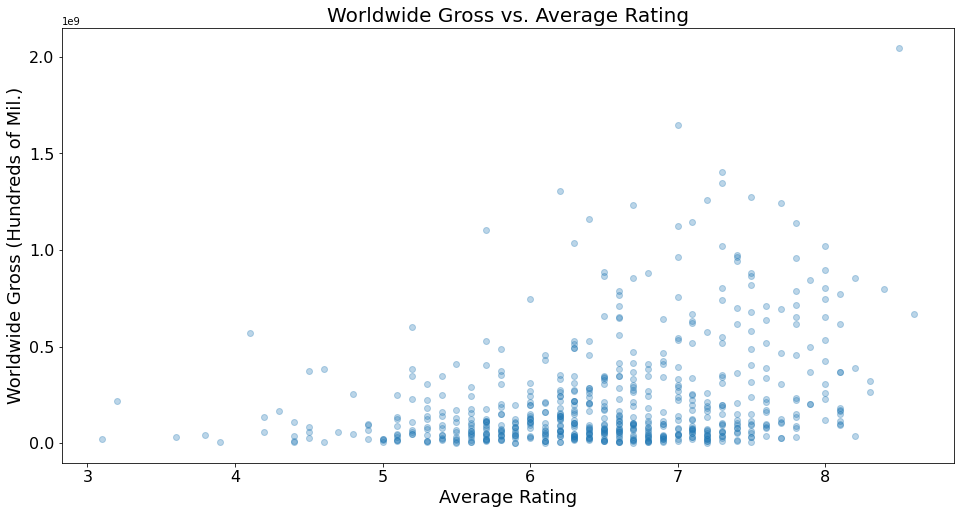

In [52]:
#Scatter plot of Worldwide Gross Sales vs. Average Rating
fig, ax = plt.subplots(figsize=(16, 8))

ax.scatter(
    x=Movies_DF_Filtered["averagerating"],
    y=Movies_DF_Filtered["worldwide_gross"],
    alpha=0.3
)

ax.set_ylabel("Worldwide Gross (Hundreds of Mil.)", fontsize = 18)
ax.set_xlabel("Average Rating", fontsize = 18)
ax.set_title("Worldwide Gross vs. Average Rating", fontsize = 20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

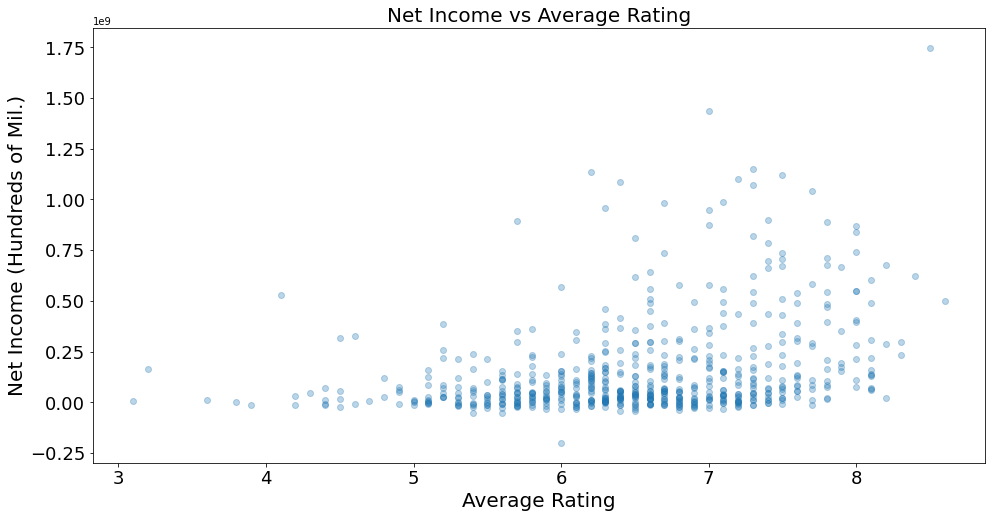

In [53]:
#Scatter plot of Net Income vs. Average Rating
fig, ax = plt.subplots(figsize=(16, 8))

ax.scatter(
    x=Movies_DF_Filtered["averagerating"],
    y=Movies_DF_Filtered['Net Income'],
    alpha=0.3
)

ax.set_ylabel("Net Income (Hundreds of Mil.)", fontsize = 20)
ax.set_xlabel("Average Rating", fontsize = 20)
ax.set_title("Net Income vs Average Rating", fontsize = 20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18);

Based on the visualizations above, we can see that ratings and financials metrics, such as worldwide sales and net income, have a very weak correlation.

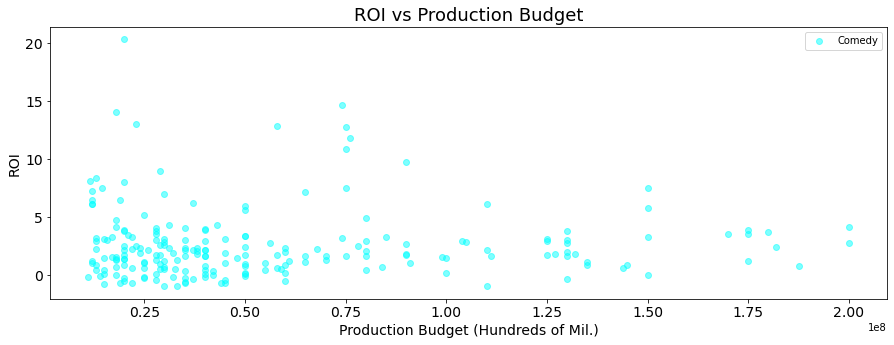

In [54]:
#Scatter plot of Production Budget vs. ROI
# Set up plot
fig, ax = plt.subplots(figsize=(15,5))


# # Plot three scatter, with reduced opacity (alpha) so we
# # can see them overlapping
ax.scatter(
    x=Comedy['production_budget'],
    y=Comedy['ROI'],
    alpha=0.5,
    color="cyan",
    label="Comedy"
)
# ax.hist(
#     x=Comedy_hist['production_budget'],
#     label="average condition",
#     bins=bins,
#     color="gray",
#     alpha=0.3
# )
# ax.hist(
#     x=below_average_condition["SalePrice"],
#     label="below average condition",
#     bins=bins,
#     color="yellow",
#     alpha=0.5
# )

# Customize labels
ax.set_title("ROI vs Production Budget", fontsize = 18)
ax.set_xlabel("Production Budget (Hundreds of Mil.)", fontsize = 14)
ax.set_ylabel("ROI", fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.legend();

Here we graph the average worldwide sales, ROI and Production Budget by release month. This will help us identify specific months that may be more profitable or larger viewership than others.

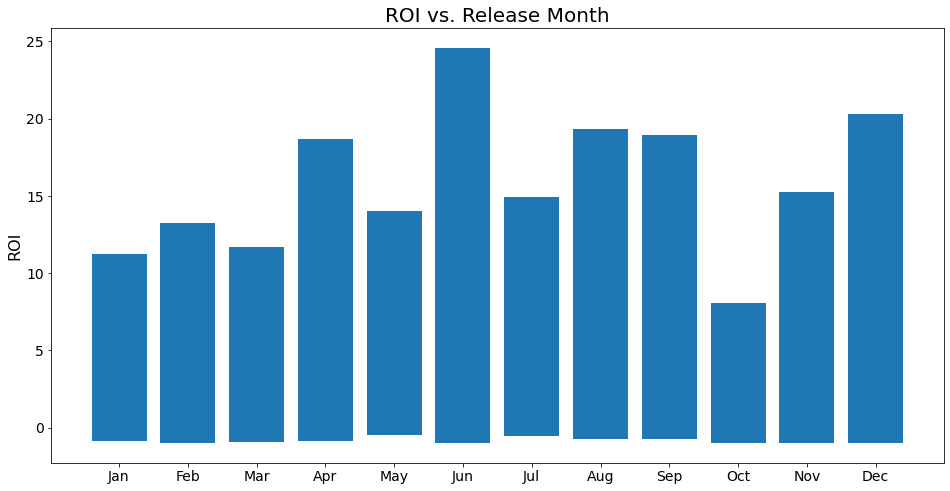

In [55]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.bar(
    height=Movies_DF_Filtered['ROI'],
    x=Movies_DF_Filtered['Month Str'],   
)

# ax.set_yticks(np.arange(0, 4,0.4))

ax.set_ylabel("ROI", fontsize = 16)
ax.set_title("ROI vs. Release Month", fontsize = 20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

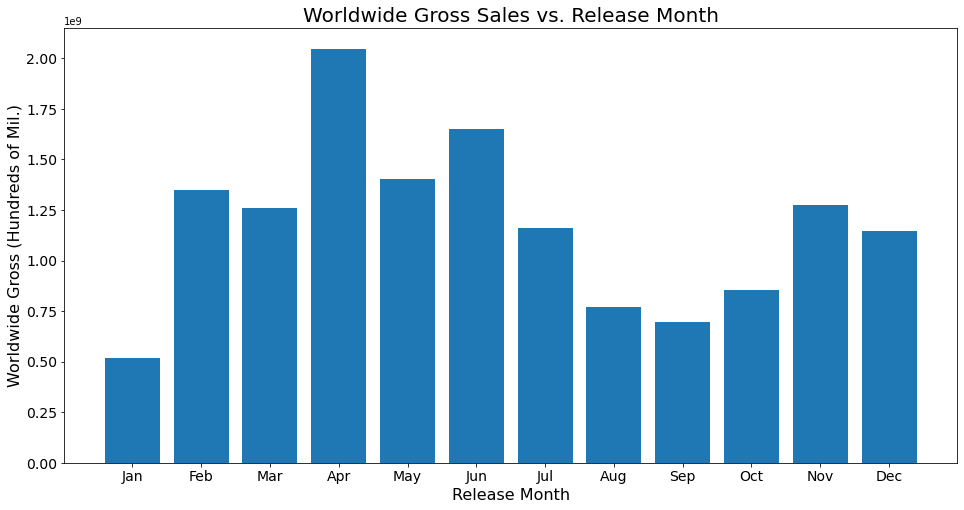

In [56]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.bar(
    height=Movies_DF_Filtered['worldwide_gross'],
    x=Movies_DF_Filtered['Month Str'],
)

# ax.set_yticks(np.arange(0, 4,0.4))

ax.set_ylabel("Worldwide Gross (Hundreds of Mil.)", fontsize = 16)
ax.set_xlabel("Release Month", fontsize = 16)
ax.set_title("Worldwide Gross Sales vs. Release Month", fontsize = 20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Finally, we compare financial metrics to various top genres.

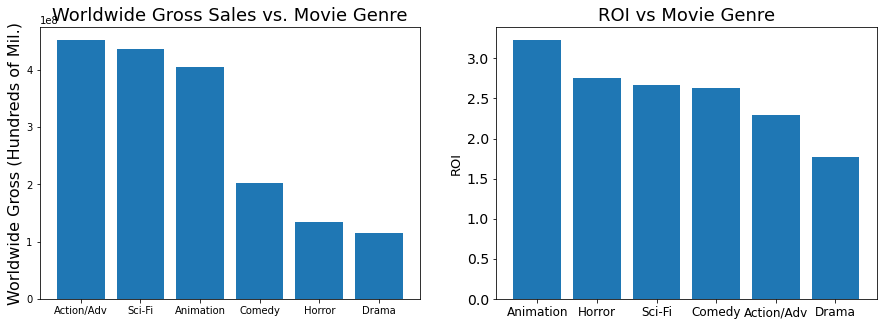

In [65]:
#Recreating Mean_DF where the numbers are ints so we can use for bar graphs
Mean_DF_Bar = pd.DataFrame(data, columns=['Movie Genre', 'Production Budget','Worldwide Gross','Net Income','ROI', 'Average Rating', 'Movie Count'])
Mean_DF_Bar = Mean_DF_Bar.set_index('Movie Genre')
Mean_DF_Bar = Mean_DF_Bar.astype(int).round(2)
Mean_DF_Bar = Mean_DF_Bar.sort_values(by='Worldwide Gross', ascending=False)


#Bar graphs for Net Income vs. Genre and ROI vs. Genre 
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))

ax1.bar(
    x = Mean_DF_Bar.index,
    height = Mean_DF_Bar['Worldwide Gross']
)

ax2.bar(
    x = Mean_DF.index,
    height = Mean_DF['ROI']
)

ax1.set_title("Worldwide Gross Sales vs. Movie Genre", fontsize = 18)
ax2.set_title("ROI vs Movie Genre", fontsize = 18)
ax1.set_ylabel("Worldwide Gross (Hundreds of Mil.)", fontsize = 16)

ax2.set_ylabel("ROI", fontsize = 13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=14);


# 6. Recommendations

Based on our data analysis and the visualizations above, our 3 recommendations are as follows:

1. Sci-Fi / Action-Adventure Movie
    - Microsoft should produce a big, action-packed sci-fi / action-adventure movie on existing IP. We think "Gears of War" would be a great first movie.
    - It should feature one of its own IP products. We think a movie on the X-Box game, "Gears of War" would be extremely successful
    - The movie should be release in or around June. These are when many of the big Marvel, DC, and Star Wars movies are released.
    
    
2. Animated 
    - Microsoft should produce a family-friend animated movie, that will further expand their viewership to kids and others who are not interested in the "Gears of War" movie
    - This movie should be released in December, around the Holiday/


3. Comedy (Possibly Romantic)
    - Finally, Microsoft should product a Comedy, potentially a Rom-Com.
    - This with again, expand their following and possibly obtain new viewers (more females, couples, etc.)
    - This movie should be released in one of the in between, yet profitable months, such as April or August.